# Ensemble Model


----
```
: 26.05.24
: zachcolinwolpe@gmail.com
```
----

In [1]:
# importing neccessary libraries 
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, BertPreTrainedModel, BertModel,AdamW
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd 
import numpy as np
import torch
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
import sklearn


from nltk.corpus import stopwords
import argparse
import logging
import string
import re
import os

from sklearn.model_selection import train_test_split, KFold
import torch.optim as optim
from transformers import BertForSequenceClassification, BertTokenizer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import BertModel
import os


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zachwolpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from Roberta_classifier import (RobertaWithActivationAndRegularization, RoBertaTokenizer)
from ML_training_code import (generate_K_Fold_data, torch_tensorize, plot_training_validation, training_loop)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zachwolpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from Bert_classifier import (BertWithActivationAndRegularization, Bert_tokenize)
from ML_training_code import (generate_K_Fold_data, torch_tensorize, plot_training_validation, training_loop)


---
## Load Pre-Trained Models
----

In [4]:
# Config ---------------------------------------->>
PATH_TO_DATA = '../data/train_test/'
SAVE_LOC = '../model-artifacts/'
BERT_MODEL_NAME = 'bert_model_debug_model.pth'
ROBERTA_MODEL_NAME = 'roberta_model_debug_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEBUG_MODE = True
BATCH_SIZE = 10
# Config ---------------------------------------->>


# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
# Thelma: updated params -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
SAVE_LOC = '../thelma-models/'
BERT_MODEL_NAME = 'bert-base-uncased.pth'
ROBERTA_MODEL_NAME = 'roberta-base.pth'
DEBUG_MODE = False
# Thelma: updated params -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

# Load data
X_test = pd.read_csv(PATH_TO_DATA + 'X_test.csv')
y_test = pd.read_csv(PATH_TO_DATA + 'y_test.csv')


# Downsample for testing
if DEBUG_MODE:
    X_test = X_test[:3]
    y_test = y_test[:3]


X_test.shape, y_test.shape

((1422, 1), (1422, 1))

----
# Load Models
----

In [5]:

# load Bert model
Bert_model = BertWithActivationAndRegularization(pretrained_model_name='bert-base-uncased', num_labels=3)

try:
    _bert_state_keys = torch.load(f'{SAVE_LOC}{BERT_MODEL_NAME}')
# Bert_model

except:
    _bert_state_keys = torch.load(f'{SAVE_LOC}{BERT_MODEL_NAME}')
    Bert_model.load_state_dict(_bert_state_keys['model_state_dict'])




In [6]:

# Load RoBerta model
RoBerta_model = RobertaWithActivationAndRegularization(pretrained_model_name='roberta-base', num_labels=3,)

try:
    RoBerta_model.load_state_dict(torch.load(f'{SAVE_LOC}{ROBERTA_MODEL_NAME}'))
except:
    _roberta_state_keys = torch.load(f'{SAVE_LOC}{ROBERTA_MODEL_NAME}')
    RoBerta_model.load_state_dict(_roberta_state_keys['model_state_dict'])



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----
# Inference Engine
----

In [7]:

def inference(model, X_test, y_test, tokenizer=Bert_tokenize, criterion=nn.CrossEntropyLoss()):
    """
    Perform inference on the model

    Return softmax probabilities, predictions, and metrics
    """    
    # evaluate on test data
    model.eval()
    input_ids_test, attention_masks_test, y_test = tokenizer(X_test, y_test)
    test_dataset = TensorDataset(input_ids_test, attention_masks_test, y_test)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    total_test_loss = 0
    correct_test = 0
    total_test = 0

    #return items
    softmax_prob = []
    predictions = []
    accuracy = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            labels = labels.reshape(-1)  # Reshape labels once

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs
            loss = criterion(logits, labels)
            total_test_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
            accuracy_test = correct_test / total_test
            print(f'Test Loss: {total_test_loss:.4f} - Test Accuracy: {accuracy_test:.4f}')

            # Get softmax probabilities
            softmax_prob.append(nn.functional.softmax(logits, dim=1).cpu().numpy())
            predictions.append(predicted.cpu().numpy())
            accuracy.append(accuracy_test)

        # flatten the list
        softmax_prob = np.concatenate(softmax_prob)
        predictions = np.concatenate(predictions)
        accuracy = np.mean(accuracy)
        
        return softmax_prob, predictions, accuracy



----
# Model Evaluation: Bert 
----

In [21]:
(softmax_prob_Bert,
 predictions_Bert,
 accuracy_Bert) = inference(Bert_model,
                            X_test,
                            y_test,
                            tokenizer=Bert_tokenize)
softmax_prob_Bert, predictions_Bert, accuracy_Bert



Test Loss: 0.9119 - Test Accuracy: 0.8000
Test Loss: 1.4482 - Test Accuracy: 0.7500
Test Loss: 2.2482 - Test Accuracy: 0.7333
Test Loss: 2.3505 - Test Accuracy: 0.8000
Test Loss: 3.3951 - Test Accuracy: 0.7800
Test Loss: 3.6045 - Test Accuracy: 0.8000
Test Loss: 4.0885 - Test Accuracy: 0.8143
Test Loss: 5.4044 - Test Accuracy: 0.8000
Test Loss: 6.7665 - Test Accuracy: 0.7889
Test Loss: 7.6394 - Test Accuracy: 0.7800
Test Loss: 8.3547 - Test Accuracy: 0.7727
Test Loss: 8.6734 - Test Accuracy: 0.7750
Test Loss: 9.2528 - Test Accuracy: 0.7769
Test Loss: 10.1618 - Test Accuracy: 0.7714
Test Loss: 10.9091 - Test Accuracy: 0.7667
Test Loss: 11.2582 - Test Accuracy: 0.7750
Test Loss: 11.7147 - Test Accuracy: 0.7706
Test Loss: 12.1509 - Test Accuracy: 0.7722
Test Loss: 12.2152 - Test Accuracy: 0.7842
Test Loss: 12.8568 - Test Accuracy: 0.7850
Test Loss: 13.4216 - Test Accuracy: 0.7857
Test Loss: 14.4621 - Test Accuracy: 0.7818
Test Loss: 14.7104 - Test Accuracy: 0.7870
Test Loss: 16.1644 - Tes

(array([[0.01167926, 0.9558555 , 0.03246526],
        [0.00395421, 0.0040915 , 0.99195427],
        [0.03429046, 0.76527894, 0.20043065],
        ...,
        [0.00571223, 0.0073569 , 0.98693085],
        [0.9406599 , 0.05330991, 0.00603017],
        [0.5350184 , 0.45488903, 0.01009255]], dtype=float32),
 array([1, 2, 1, ..., 2, 0, 0]),
 0.7997736432553271)

In [22]:
softmax_prob_Bert, accuracy_Bert

(array([[0.01167926, 0.9558555 , 0.03246526],
        [0.00395421, 0.0040915 , 0.99195427],
        [0.03429046, 0.76527894, 0.20043065],
        ...,
        [0.00571223, 0.0073569 , 0.98693085],
        [0.9406599 , 0.05330991, 0.00603017],
        [0.5350184 , 0.45488903, 0.01009255]], dtype=float32),
 0.7997736432553271)

----
# Model Evaluation: RoBerta 
----

In [23]:
(softmax_prob_RoBerta,
 predictions_RoBerta,
 accuracy_RoBerta) = inference(RoBerta_model,
                            X_test,
                            y_test,
                            tokenizer=RoBertaTokenizer)
softmax_prob_RoBerta, predictions_RoBerta, accuracy_RoBerta



Test Loss: 1.3179 - Test Accuracy: 0.7000
Test Loss: 2.4354 - Test Accuracy: 0.6500
Test Loss: 3.4487 - Test Accuracy: 0.6667
Test Loss: 4.2255 - Test Accuracy: 0.7000
Test Loss: 5.4550 - Test Accuracy: 0.7000
Test Loss: 5.4869 - Test Accuracy: 0.7500
Test Loss: 5.4962 - Test Accuracy: 0.7857
Test Loss: 7.0697 - Test Accuracy: 0.7625
Test Loss: 7.8033 - Test Accuracy: 0.7778
Test Loss: 9.3687 - Test Accuracy: 0.7600
Test Loss: 9.7111 - Test Accuracy: 0.7727
Test Loss: 9.7933 - Test Accuracy: 0.7917
Test Loss: 10.3659 - Test Accuracy: 0.8000
Test Loss: 11.3466 - Test Accuracy: 0.7929
Test Loss: 12.3766 - Test Accuracy: 0.7867
Test Loss: 12.7735 - Test Accuracy: 0.7937
Test Loss: 13.3210 - Test Accuracy: 0.8000
Test Loss: 13.9617 - Test Accuracy: 0.8000
Test Loss: 14.0921 - Test Accuracy: 0.8053
Test Loss: 14.5240 - Test Accuracy: 0.8100
Test Loss: 15.0799 - Test Accuracy: 0.8143
Test Loss: 16.2730 - Test Accuracy: 0.8045
Test Loss: 16.5901 - Test Accuracy: 0.8087
Test Loss: 18.3639 - Te

(array([[0.05206173, 0.93850005, 0.00943821],
        [0.00123778, 0.00123432, 0.9975279 ],
        [0.01509286, 0.20752849, 0.7773786 ],
        ...,
        [0.0068357 , 0.00525033, 0.987914  ],
        [0.99210876, 0.00575821, 0.002133  ],
        [0.8583273 , 0.13579574, 0.00587694]], dtype=float32),
 array([1, 2, 2, ..., 2, 0, 0]),
 0.8064607187345204)

----
# Ensemble Model
----

Ensemble methods:

To ensemble your two deep learning classifiers (Bert and RoBerta models), you can average their predictions. Here's a concise guide on how to implement this in PyTorch:
1. Load Both Models: Ensure both models are loaded and set to evaluation mode.
2. Prepare the Data: Tokenize and prepare your data as required by both models. Since you're using different tokenizers for Bert and RoBerta, you'll need to prepare the inputs separately for each model.
3. Get Predictions from Both Models: Pass the test data through both models to get the logits (raw model outputs before applying softmax).
4. Average the Logits: Average the logits obtained from both models. This simple method of ensembling is often quite effective.
5. Apply Softmax and Determine Final Predictions: Apply softmax to the averaged logits to get probabilities, and then determine the final predictions (e.g., by taking the argmax).
Here's how you could implement this:



This code snippet averages the predictions from both models. You can also explore other ensembling techniques like weighted averaging or voting based on validation set performance.

In [9]:
def ensemble_inference(model1, model2, X_test, y_test, tokenizers=[Bert_tokenize, RoBertaTokenizer], criterion=nn.CrossEntropyLoss()):
    """
    Perform inference on the model

    Return softmax probabilities, predictions, and metrics
    """    
    # Assuming model_bert and model_roberta are your loaded models
    model1.eval()
    model2.eval()

    # Prepare data for both models
    input_ids_bert, attention_masks_bert, _ = tokenizers[0](X_test, y_test)
    input_ids_roberta, attention_masks_roberta, _ = tokenizers[1](X_test, y_test)

    # Convert to appropriate device
    input_ids_bert, attention_masks_bert = input_ids_bert.to(device), attention_masks_bert.to(device)
    input_ids_roberta, attention_masks_roberta = input_ids_roberta.to(device), attention_masks_roberta.to(device)

    # Get logits from both models
    with torch.no_grad():
        logits_model1 = model1(input_ids=input_ids_bert, attention_mask=attention_masks_bert)
  
        logits_model2 = model2(input_ids=input_ids_roberta, attention_mask=attention_masks_roberta)

        # Average the logits
        averaged_logits = (logits_model1 + logits_model2) / 2

        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(averaged_logits, dim=1)

        # Get the predicted classes
        _, predicted_classes = torch.max(probabilities, 1)

        # Calculate accuracy
        acc = torch.sum(predicted_classes == torch.tensor(y_test['Sentiment'])) / len(y_test)

        return probabilities.cpu().numpy(), predicted_classes.cpu().numpy(), acc.item()

        

In [10]:
# Ensemble Inference
(softmax_prob_ensemble,
 predictions_ensemble,
 accuracy_ensemble) = ensemble_inference(Bert_model,
                                        RoBerta_model,
                                        X_test,
                                        y_test,
                                        tokenizers=[Bert_tokenize, RoBertaTokenizer])


(softmax_prob_ensemble,
 predictions_ensemble,
 accuracy_ensemble) 

(array([[0.14485256, 0.7910762 , 0.06407132],
        [0.0308138 , 0.04160151, 0.92758477],
        [0.07597816, 0.35849625, 0.56552565],
        ...,
        [0.06800987, 0.07859176, 0.8533984 ],
        [0.8673193 , 0.09128197, 0.04139874],
        [0.6086164 , 0.33969036, 0.05169322]], dtype=float32),
 array([1, 2, 2, ..., 2, 0, 0]),
 0.8192686438560486)

In [11]:
y_test.shape

(1422, 1)

In [14]:
# Compute evaluation metrics
def eval_metrics(predictions, y_test):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    return accuracy, precision, recall, f1, conf_matrix

In [15]:
accuracy, precision, recall, f1, conf_matrix = eval_metrics(predictions_ensemble, y_test['Sentiment'])

In [16]:
print(f'Accuracy:   {accuracy:.4f}')
print(f'Precision:  {precision:.4f}')
print(f'Recall:     {recall:.4f}')
print(f'F1 Score:   {f1:.4f}')
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy:   0.8193
Precision:  0.8184
Recall:     0.8193
F1 Score:   0.8180
Confusion Matrix: 
[[360  82  24]
 [ 68 392  49]
 [  7  27 413]]


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       466
           1       0.78      0.77      0.78       509
           2       0.85      0.92      0.89       447

    accuracy                           0.82      1422
   macro avg       0.82      0.82      0.82      1422
weighted avg       0.82      0.82      0.82      1422



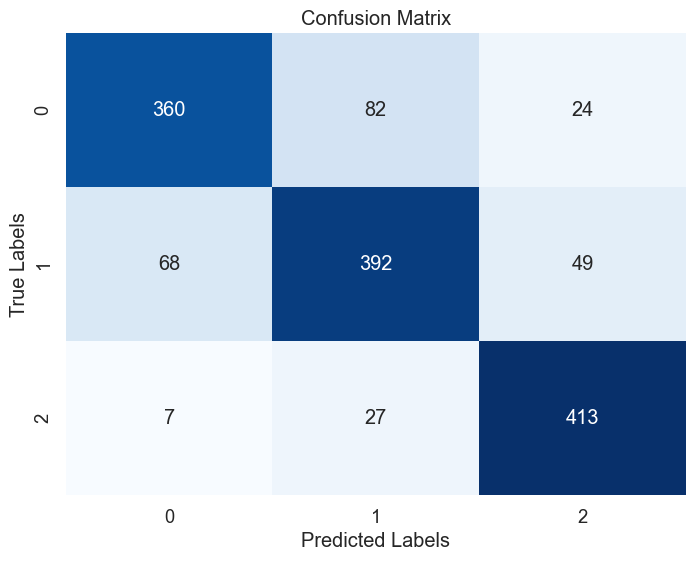

In [17]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions_ensemble))

# Plot confusion matrix with blue colors
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [24]:
# # evaluate on test data
# Bert_model.eval()
# criterion = nn.CrossEntropyLoss()
# input_ids_test, attention_masks_test, y_test = Bert_tokenize(X_test, y_test)
# test_dataset = TensorDataset(input_ids_test, attention_masks_test, y_test)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# total_test_loss = 0
# correct_test = 0
# total_test = 0

# with torch.no_grad():
#     for batch in test_dataloader:
#         input_ids, attention_mask, labels = batch
#         input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
#         labels = labels.reshape(-1)  # Reshape labels once

#         outputs = Bert_model(input_ids=input_ids, attention_mask=attention_mask)
#         logits = outputs
#         loss = criterion(logits, labels)
#         total_test_loss += loss.item()

#         _, predicted = torch.max(logits, 1)
#         correct_test += (predicted == labels).sum().item() 
#         total_test += labels.size(0)
#         accuracy_test = correct_test / total_test
#         print(f'Test Loss: {total_test_loss:.4f} - Test Accuracy: {accuracy_test:.4f}')


In [25]:

# Evaluate on test data
RoBerta_model.eval()
criterion = nn.CrossEntropyLoss()
input_ids_test, attention_masks_test, y_test = RoBertaTokenizer(X_test, y_test)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

total_test_loss = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        labels = labels.reshape(-1)  # Reshape labels once

        outputs = RoBerta_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs
        loss = criterion(logits, labels)
        total_test_loss += loss.item()

        _, predicted = torch.max(logits, 1)
        correct_test += (predicted == labels).sum().item() 
        total_test += labels.size(0)
        accuracy_test = correct_test / total_test
        print(f'Test Loss: {total_test_loss:.4f} - Test Accuracy: {accuracy_test:.4f}')
        

Test Loss: 1.1097 - Test Accuracy: 0.3333


In [26]:
# Assuming model_bert and model_roberta are your loaded models
model_bert.eval()
model_roberta.eval()

# Prepare data for both models
input_ids_bert, attention_masks_bert, _ = Bert_tokenize(X_test, y_test)
input_ids_roberta, attention_masks_roberta, _ = RoBertaTokenizer(X_test, y_test)

# Convert to appropriate device
input_ids_bert, attention_masks_bert = input_ids_bert.to(device), attention_masks_bert.to(device)
input_ids_roberta, attention_masks_roberta = input_ids_roberta.to(device), attention_masks_roberta.to(device)

# Get logits from both models
with torch.no_grad():
    outputs_bert = model_bert(input_ids=input_ids_bert, attention_mask=attention_masks_bert)
    logits_bert = outputs_bert.logits  # Adjust depending on your model's output

    outputs_roberta = model_roberta(input_ids=input_ids_roberta, attention_mask=attention_masks_roberta)
    logits_roberta = outputs_roberta.logits  # Adjust depending on your model's output

    # Average the logits
    averaged_logits = (logits_bert + logits_roberta) / 2

    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(averaged_logits, dim=1)

    # Get the predicted classes
    _, predicted_classes = torch.max(probabilities, 1)

# Evaluate the predictions as needed

NameError: name 'model_bert' is not defined